In [202]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
#from source.utils import *
from source.preprocess import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [204]:
path = "../../Desktop/DLC_social_1/"
path2 = "../../Desktop/DLC_social_2/"

# Set up and design the project

In [205]:
with open('{}DLC_social_1_exp_conditions.pickle'.format(path), 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [207]:
Treatment_dict["WT+NS"]

['Test 6DLC',
 'Test 15DLC',
 'Test 24DLC',
 'Test 29DLC',
 'Test 38DLC',
 'Test 47DLC',
 'Day2Test8DLC',
 'Day2Test13DLC',
 'Day2Test22DLC',
 'Day2Test31DLC',
 'Day2Test40DLC']

In [5]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [6]:
%%time
DLC_social_1 = project(path=path,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   subset_condition="B",
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.63 s, sys: 818 ms, total: 3.45 s
Wall time: 1.11 s


In [7]:
%%time
DLC_social_2 = project(path=path2,#Path where to find the required files
                   smooth_alpha=0.90,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   subset_condition="B",
                   video_format='.mp4',
                   table_format='.h5')

CPU times: user 6.55 s, sys: 1.02 s, total: 7.58 s
Wall time: 1.58 s


# Run project

In [8]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 5.52 s, sys: 460 ms, total: 5.98 s
Wall time: 6.33 s


source.preprocess.coordinates

In [9]:
%%time
DLC_social_2_coords = DLC_social_2.run(verbose=True)
print(DLC_social_2_coords)
type(DLC_social_2_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
DLC analysis of 31 videos
CPU times: user 3.18 s, sys: 286 ms, total: 3.47 s
Wall time: 3.61 s


source.preprocess.coordinates

# Generate coords

In [170]:
%%time
ptest = DLC_social_1_coords.get_coords(center="B_Center", polar=True, speed=0, length='00:10:00')
ptest._type

ptest2 = DLC_social_2_coords.get_coords(center="B_Center", polar=True, speed=0, length='00:10:00')
ptest2._type

CPU times: user 2.06 s, sys: 110 ms, total: 2.17 s
Wall time: 2.17 s


'coords'

In [171]:
ptest['Test 13DLC'].columns.levels

FrozenList([['B_Center', 'B_Left_ear', 'B_Left_flank', 'B_Nose', 'B_Right_ear', 'B_Right_flank', 'B_Tail_base'], ['phi', 'rho']])

In [12]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

dtest2 = DLC_social_2_coords.get_distances(speed=0, length='00:10:00')
dtest2._type

CPU times: user 79.3 ms, sys: 44.4 ms, total: 124 ms
Wall time: 124 ms


'dists'

In [13]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

atest2 = DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest2._type

CPU times: user 235 ms, sys: 136 ms, total: 371 ms
Wall time: 377 ms


'angles'

# Visualization playground

In [14]:
ptest.plot_heatmaps(['B_Nose'], i=2)

NotImplementedError: Heatmaps only available for cartesian coordinates. Set polar to False in get_coordinates and try again

In [ ]:
#Plot animation of trajectory over time with different smoothings
#plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
#         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Mouse Center Trajectory using different exponential smoothings')
#plt.legend()
#plt.show()

# Dimensionality reduction playground

In [ ]:
#pca = ptest.pca(4, 1000)

In [ ]:
#plt.scatter(*pca[0].T)
#plt.show()

# Preprocessing playground

In [190]:
mtest = merge_tables(
                      DLC_social_1_coords.get_coords(center="B_Center", polar=False, length='00:10:00', align='B_Nose')
                      #DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
                      #DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'),
                    )

In [191]:
mtest2 = merge_tables(
                      DLC_social_2_coords.get_coords(center="B_Center", polar=False, length='00:10:00', align='B_Nose'),
                      #DLC_social_2_coords.get_distances(speed=0, length='00:10:00'),
                      #DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00'),
                    )

In [195]:
pttest = mtest.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,
                          shift=0, scale="standard", align=True)
pttest.shape

(70504, 11, 12)

In [196]:
pttest2 = mtest2.preprocess(window_size=11, window_step=1, filter="gaussian", sigma=55,
                            shift=0, scale="standard", align=True)
pttest2.shape

(465021, 11, 12)

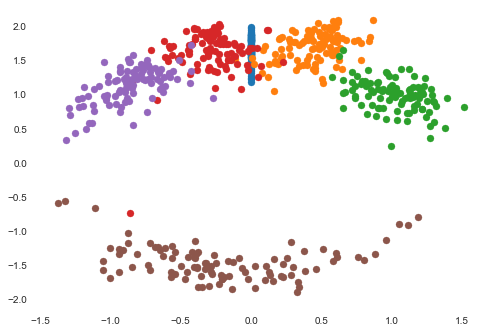

In [201]:
n = 100

#plt.scatter(pttest[:n,5,0], pttest[:n,5,1])
#plt.scatter(pttest[:n,5,2], pttest[:n,5,3])

plt.scatter(pttest[:n,5,0], pttest[:n,5,1])
plt.scatter(pttest[:n,5,2], pttest[:n,5,3])
plt.scatter(pttest[:n,5,4], pttest[:n,5,5])
plt.scatter(pttest[:n,5,6], pttest[:n,5,7])
plt.scatter(pttest[:n,5,8], pttest[:n,5,9])
plt.scatter(pttest[:n,5,10], pttest[:n,5,11])

#plt.scatter(pttest[:n,5,4], pttest[:n,5,5])
#plt.scatter(pttest[:n,5,6], pttest[:n,5,7])
#plt.scatter(pttest[:n,5,8], pttest[:n,5,9])

#plt.xlim(-60,60)
#plt.ylim(-60,60)
plt.show()

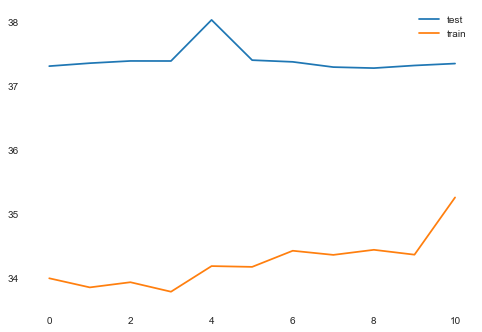

In [182]:
plt.plot(pttest2[2,:,3], label='test')
plt.plot(pttest[2,:,3], label='train')
plt.legend()
plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [33]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [34]:
NAME = 'Baseline_AE_512_wu10_slide10_gauss_fullval'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_GMVAE

In [36]:
encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()
ae.build(pttest.shape)

In [37]:
ae.summary()

Model: "SEQ_2_SEQ_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SEQ_2_SEQ_Encoder (Sequentia (None, 16)                1769680   
_________________________________________________________________
SEQ_2_SEQ_Decoder (Sequentia multiple                  2678172   
Total params: 4,405,660
Trainable params: 4,401,308
Non-trainable params: 4,352
_________________________________________________________________


In [176]:
tf.keras.backend.clear_session()

encoder, generator, grouper, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_GMVAE(pttest.shape,
                                                                               loss='ELBO',
                                                                               number_of_components=10,
                                                                               kl_warmup_epochs=10,
                                                                               mmd_warmup_epochs=10,
                                                                               encoding=16,
                                                                               predictor=False).build()
#gmvaep.build(pttest.shape)

In [177]:
#gmvaep.summary()

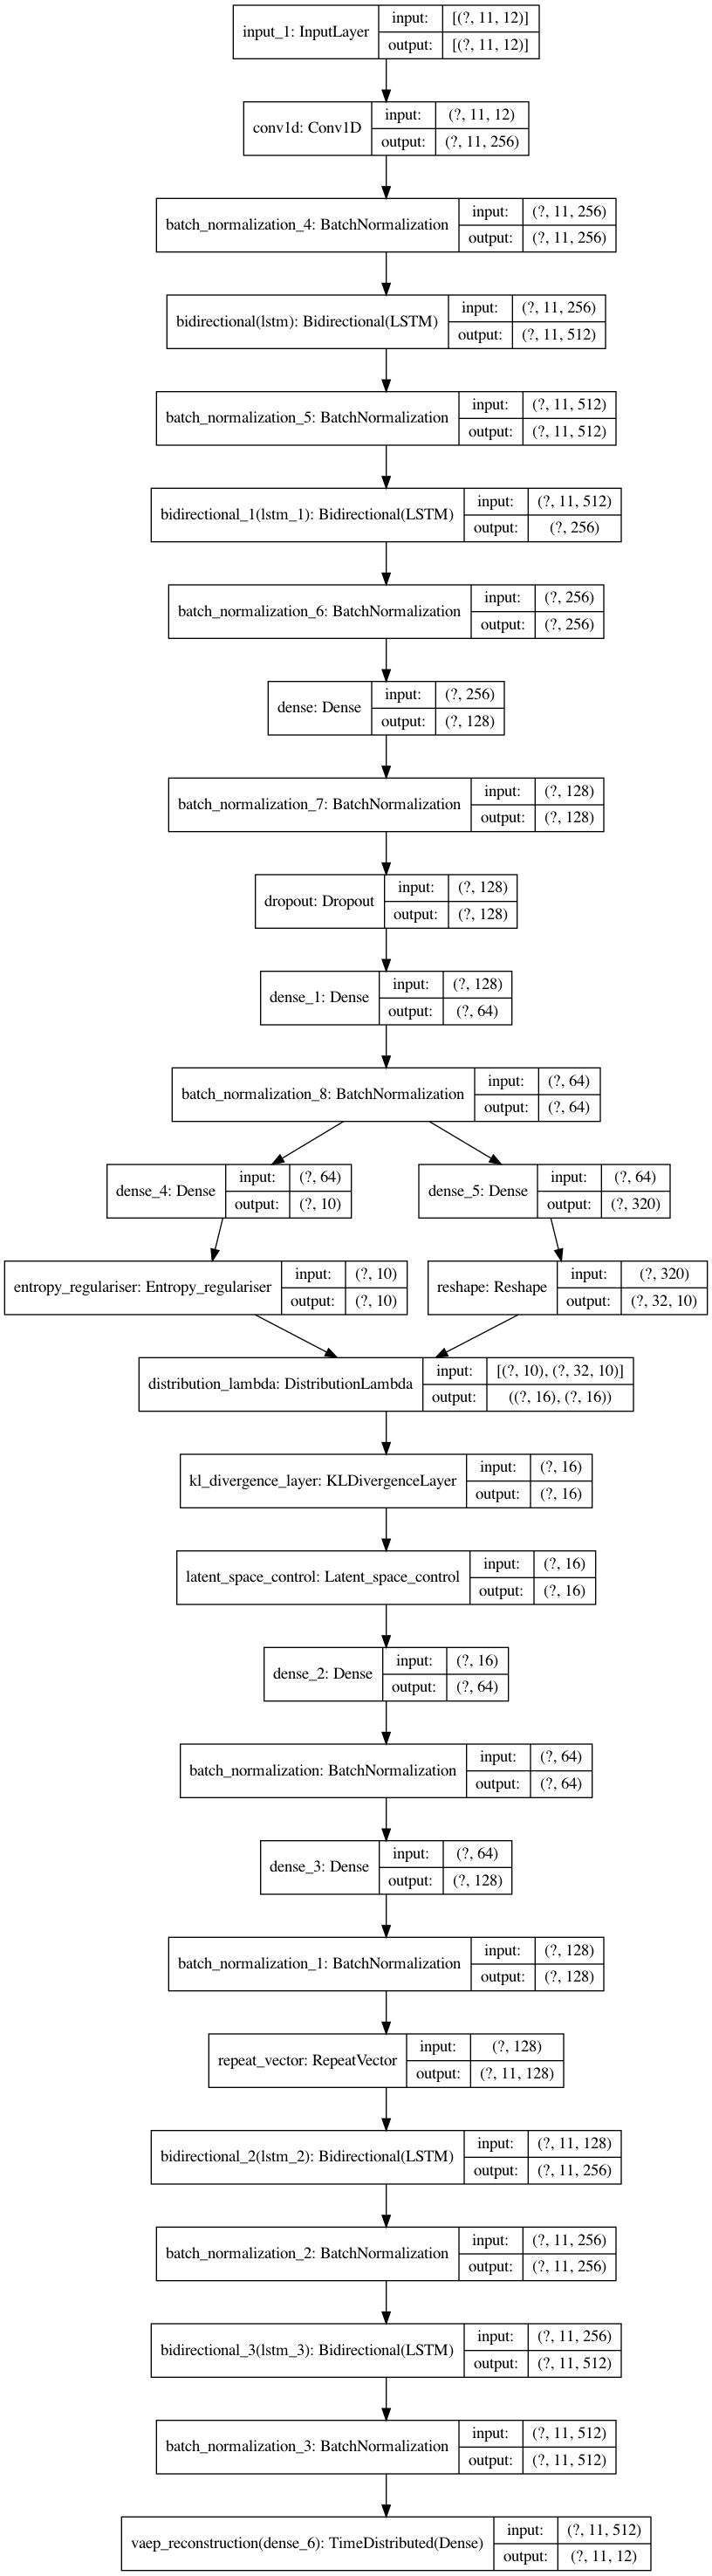

In [178]:
tf.keras.utils.plot_model(gmvaep, show_shapes=True)

In [179]:
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-3 * 10**(epoch / 20))

In [ ]:
# tf.config.experimental_run_functions_eagerly(False)
# history = ae.fit(x=pttest[:-1], y=[pttest[:-1],pttest[1:]], epochs=100, batch_size=512, verbose=1,
#                    validation_data=(pttest2[:-1], [pttest2[:-1],pttest2[1:]]),
#                    callbacks=[tensorboard_callback])

In [ ]:
# #GMVAEP witout prediction
#tf.config.experimental_run_functions_eagerly(False)
# history = gmvaep.fit(x=pttest[:-1], y=pttest[:-1], epochs=100, batch_size=512, verbose=1,
#                   validation_data=(pttest2[:-1], pttest2[:-1]),
#                   callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

In [ ]:
gmvaep.summary()

In [ ]:
# GMVAEP with prediction
# tf.config.experimental_run_functions_eagerly(False)
# history = gmvaep.fit(x=pttest[:-1], y=[pttest[:-1],pttest[1:]], epochs=100, batch_size=512, verbose=1,
#                      validation_data=(pttest2[:-1], [pttest2[:-1],pttest2[1:]]),
#                      callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

## Encoding interpretation playground

In [ ]:
#The main goal of this section is to explore how to retrieve a given set of frames from the corresponding video

In [ ]:
interpret = pd.read_hdf("./visualizations/dash_data_1.h5")
interpret = interpret.astype(float)
interpret

In [ ]:
confidence = interpret.confidence[interpret.epoch]

In [ ]:
import plotly.express as px

In [ ]:
fig = px.histogram(interpret.loc[interpret["epoch"] > 1], x="confidence", animation_frame="epoch")

fig.show()

In [ ]:
fig = px.histogram(
    data_frame=interpret,
    x="confidence",
    animation_frame="epoch",
    labels={"confidence": "Confidence in best cluster"},
    width=550,
    height=500,
    color_discrete_sequence=px.colors.qualitative.T10,
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1
fig.update_xaxes(showgrid=True, range=[-0.05, 1.05])

fig.update_layout({"paper_bgcolor": "rgba(0, 0, 0, 0)"})

# Post clustering analysis playground

In [ ]:
# Adjusted Rand Index (ARI) for subsequent clustering rounds (how stable are the retrieved clusters?)

In [ ]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score

In [ ]:
labels = pd.read_csv("./DeepOF_cluster_assignments_across_5_runs_20200714-164723.csv", index_col=0)
labels.head()

In [ ]:
from itertools import combinations

In [ ]:
ari_dist = []
for i in combinations(range(5), 2):
    ari_dist.append(adjusted_rand_score(labels[str(i[0])], labels[str(i[1])]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ari_dist

In [ ]:
for i in range(5):
    print(Counter(labels[str(i)]))

In [ ]:
adjusted_rand_score(labels[0], labels[3])

In [ ]:
sns.distplot(ari_dist)
plt.xlabel("Adjusted Rand Index")
plt.ylabel("Count")
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
from scipy.stats import entropy

In [ ]:
entropy(np.array([0.5,0,0.5,0]))

In [ ]:
tfd.Categorical(np.array([0.5,0.5,0.5,0.5])).entropy()

In [ ]:
pk = np.array([0.5,0,0.5,0])

In [ ]:
np.log(pk)

In [ ]:
np.clip(np.log(pk), 0, 1)

In [ ]:
-np.sum(pk*np.array([-0.69314718,        0, -0.69314718,        0]))

In [ ]:
import tensorflow.keras.backend as K
entropy = K.sum(tf.multiply(pk, tf.where(~tf.math.is_inf(K.log(pk)), K.log(pk), 0)), axis=0)
entropy

In [ ]:
# Cluster Merging

In [226]:
gmvaep.load_weights("GMVAE_components=10_loss=ELBO_kl_warmup=20_mmd_warmup=5_20200720-232437_final_weights.h5")

In [227]:
clusts = grouper.predict(pttest[:5000])

In [228]:
clusts

array([[0.10010283, 0.10001488, 0.09990375, ..., 0.10015588, 0.10001326,
        0.0996023 ],
       [0.1000577 , 0.10007282, 0.09992357, ..., 0.10016638, 0.1000193 ,
        0.09953061],
       [0.1000585 , 0.10008217, 0.09991302, ..., 0.10016595, 0.10002792,
        0.09953017],
       ...,
       [0.10004222, 0.09996796, 0.09988689, ..., 0.10015707, 0.10000951,
        0.09977443],
       [0.09998595, 0.10000338, 0.09987012, ..., 0.10015205, 0.10002563,
        0.09981885],
       [0.10004769, 0.0999479 , 0.0998627 , ..., 0.10000892, 0.10002322,
        0.10004033]], dtype=float32)

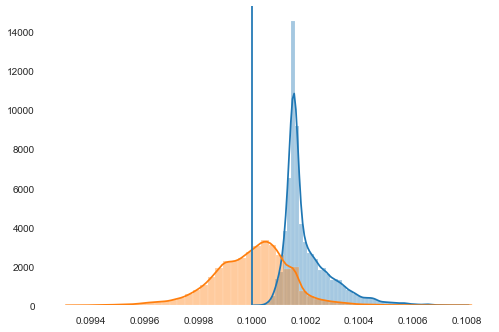

In [229]:
sns.distplot(np.max(clusts, axis=1))
sns.distplot(clusts.reshape(clusts.shape[0] * clusts.shape[1]))
plt.axvline(1/10)
plt.show()

In [230]:
clusts = np.argmax(clusts, axis=1)

In [231]:
from collections import Counter
Counter(clusts)

Counter({7: 1959,
         3: 758,
         8: 535,
         0: 84,
         9: 671,
         2: 829,
         5: 70,
         4: 20,
         6: 70,
         1: 4})

In [232]:
gauss_means = gmvaep.get_layer(name="dense_4").get_weights()[0][:32]
gauss_variances = tf.keras.activations.softplus(gmvaep.get_layer(name="dense_4").get_weights()[0][32:]).numpy()

In [233]:
gauss_means.shape == gauss_variances.shape

True

In [234]:
k=10
n=100
samples = []
for i in range(k):
    samples.append(np.random.normal(gauss_means[:,i], gauss_variances[:,i], size=(100,32)))

In [235]:
from scipy.stats import ttest_ind
test_matrix = np.zeros([k,k])
for i in range(k):
    for j in range(k):
        test_matrix[i][j] = np.mean(ttest_ind(samples[i], samples[j], equal_var=False)[1])

In [236]:
threshold = 0.55
np.sum(test_matrix > threshold)

40

In [267]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
reducer = TSNE(n_components=2, perplexity=15)

In [268]:
rep = reducer.fit_transform(encoder.predict(pttest[:5000]), clusts)

In [269]:
rep.shape

(5000, 2)

In [270]:
import plotly.express as px

In [271]:
df = pd.DataFrame({"rep0":rep[:,0],"rep1":rep[:,1],"clusters":["A"+str(i) for i in clusts]})

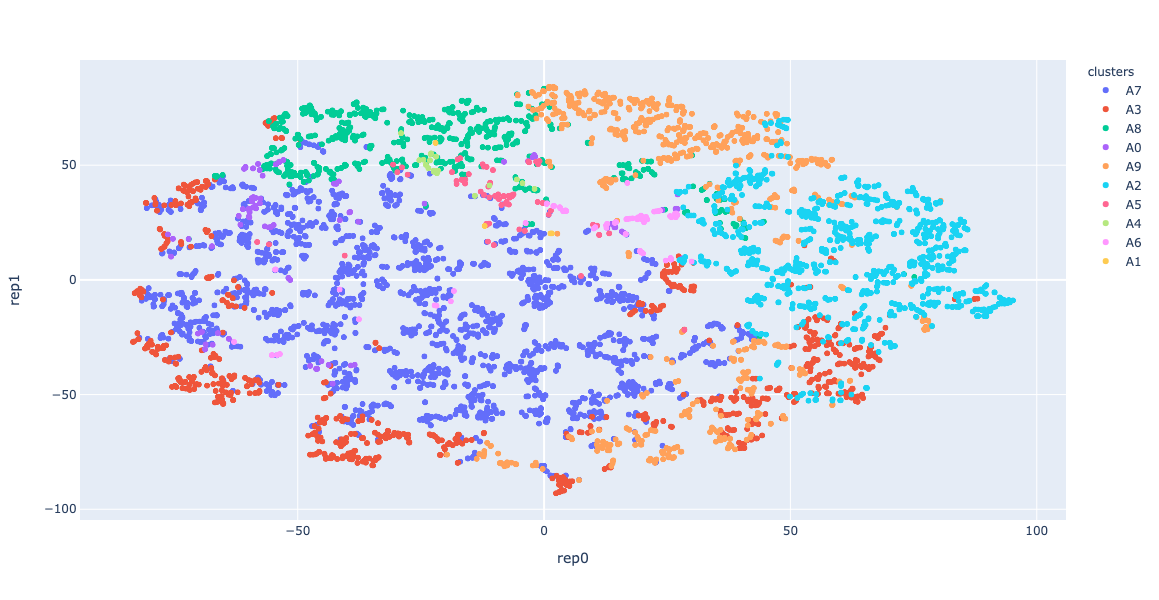

In [272]:
px.scatter(data_frame=df, x="rep0", y="rep1", color="clusters", width=600, height=600)